# Figure notebook

Author: _Pim Dankloff_

Dependencies:

In [1]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_selection._mutual_info import mutual_info_regression
from scipy.optimize import root_scalar, minimize

# custom anlysis scripts
from analysis.models import szyszkowski_model, dynamic_st_model
from analysis.utils import fit_model, calc_st_at_cmc, calculate_C20
from utils.data_processing import smooth
from analysis.mixtures.interaction_parameter import *

C:\Users\pimda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


General settings:

In [2]:
figure_dpi = 300

## Figure 1

### illustration isotherm

import data & fit model

In [3]:
df = pd.read_csv("data/example_experimental_isotherm/SDS.csv")
c_1 = df["Concentration"] / 1000
st_1 = df["Surface Tension"] / 1000
obs_1 = (c_1, st_1)
parameters = ["cmc", "gamma_max", "Kad"]

# fit isotherm model
post_pred_1, x_new_1 = fit_model(
    obs_1, model=szyszkowski_model, parameters=parameters, outlier_check=False
)

# unit conversion
x_new_1 = x_new_1 * 1000
x_obs_1, y_obs_1 = obs_1
x_obs_1 = x_obs_1 * 1000
y_obs_1 = y_obs_1 * 1000

# mean and std of posterior predictive distribution
st_fit_mu = post_pred_1["obs"].mean(axis=0) * 1000
st_fit_std_1 = post_pred_1["obs"].std(axis=0) * 1000

sample: 100%|██████████| 1500/1500 [00:02<00:00, 600.46it/s, 63 steps of size 3.79e-02. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad    186.56     14.38    186.40    162.28    209.06    294.83      1.00
        cmc      0.01      0.00      0.01      0.01      0.01    308.71      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    281.41      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    350.09      1.01

Number of divergences: 0


plot isotherm

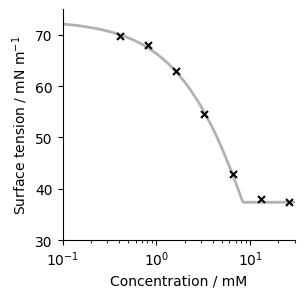

In [14]:
fig, ax1 = plt.subplots(figsize=(3, 3))
ax1.plot(x_new_1, st_fit_mu, c="black", alpha=0.3, linewidth=2)
ax1.scatter(
    x_obs_1,
    y_obs_1,
    s=25,
    zorder=100,
    color="black",
    marker="x",
    alpha=1,
)


# axes settings
fontsize_labels = 10

ax1.set_ylim(35, 75)
ax1.set_yticks(np.arange(30, 76, 10))
ax1.set_xlim(0.1, 30)
ax1.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)
ax1.set_xlabel("Concentration / mM", fontsize=fontsize_labels)
ax1.set_xscale("log")
sns.despine()

# save
fig.savefig(
    "figures/figure1/example_isotherm.svg",
    dpi=figure_dpi,
    bbox_inches="tight",

)

## Figure 2

### Worthington number dependency on volume of pendant drop

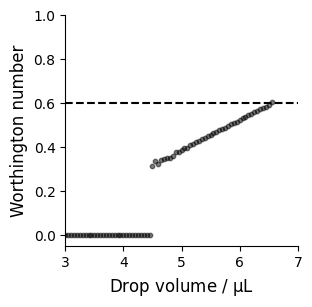

In [42]:
# import data
df = pd.read_csv("data/worthington_dropvolume/water.csv")
wo = df["Wo"]
vol = df["drop volume (uL)"]

# figure
fig, ax = plt.subplots(figsize=(3, 3))
sns.despine()

# plot experimental data + horizontal limit
ax.scatter(vol, wo, s=10, color="black", alpha=0.5)
ax.axhline(y=0.6, color="black", linestyle="--")

# labels
fontsize_labels = 12
ax.set_xlabel(r"Drop volume / $\mathrm{\mu L}$", fontsize=fontsize_labels)
ax.set_ylabel(r"Worthington number", fontsize=fontsize_labels)

# limits
ax.set_xlim(3, 7)
ax.set_ylim(-0.05, 1)

# save
fig.savefig("figures/figure2/worthington_dropvolume.svg", dpi=figure_dpi, bbox_inches="tight")

### Dynamic surface tension example

Import data & fit model

In [15]:
# import data
df = pd.read_csv("data/example_dynamic_surface_tension/C12E4_46mM.csv")
t = df["Time (s)"].values
st_1 = df["Surface Tension (mN/m)"].values

# we slice the data to remove no (hanging) droplet region
idx = np.argmax(st_1) + 1
t = t[idx:]
st_1 = st_1[idx:]

# # fit kinetic model
obs_1 = (t, st_1)
parameters = ["st_messo", "t_star", "n"]
post_pred_1, x_new_1 = fit_model(
    obs_1, model=dynamic_st_model, parameters=parameters, outlier_check=False
)

sample: 100%|██████████| 1500/1500 [00:14<00:00, 103.78it/s, 7 steps of size 3.88e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         n      2.14      0.03      2.14      2.10      2.18    517.74      1.00
     sigma      0.51      0.02      0.51      0.47      0.54    842.26      1.00
  st_messo     37.92      0.06     37.92     37.84     38.03    656.86      1.00
    t_star     26.79      0.14     26.78     26.53     26.98    863.47      1.00

Number of divergences: 0


Plot dynamic surface tension

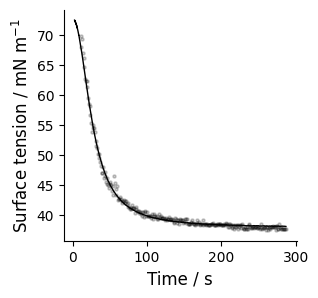

In [16]:
# figure
fig, ax = plt.subplots(figsize=(3, 3))
sns.despine()

# plot data and fit
ax.scatter(t, st_1, label="data", s=5, color="black", alpha=0.2)
ax.plot(x_new_1, post_pred_1["obs"].mean(axis=0), label="fit", color="black", linewidth=1)

# labels
fontsize_labels = 12
ax.set_xlabel("Time / s", fontsize=fontsize_labels)
ax.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)

# save
fig.savefig(
    "figures/figure2/dynamic_surface_tension.svg", dpi=figure_dpi, bbox_inches="tight"
)

### Comparison pendant drop measurements with literature values

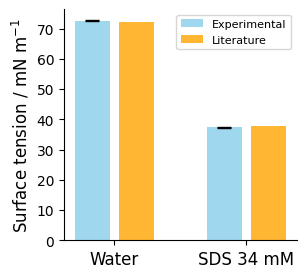

In [37]:
# import data
df = pd.read_csv("data/comparison_pendantprop_literature/data.csv")
df_water = df[df["solution"] == "water"]
df_SDS = df[df["solution"] == "SDS"]
water_mu = df_water["needle mu"].values[0]
water_std = df_water["needle std"].values[0]
SDS_mu = df_SDS["needle mu"].values[0]
SDS_std = df_SDS["needle std"].values[0]

# Experimental values
labels = ["Water", "SDS 34 mM"]
means = [water_mu, SDS_mu]
stds = [water_std, SDS_std]

# Literature values
lit_labels = ["Water (lit)", "SDS (lit)"]
lit_means = [72.2, 38]  # mN/m

# Combine labels and values for plotting
all_labels = labels + lit_labels
all_means = means + lit_means
all_stds = stds + [0, 0]  # No error bars for literature values

# Create a bar graph with error bars
plt.figure(figsize=(3, 3))

bar_width = 1  # Width of each bar
group_spacing = 1  # Spacing between groups

# Plot experimental values
x_exp = np.arange(len(labels)) * (2 * bar_width + group_spacing)
plt.bar(
    x_exp, means, yerr=stds, capsize=5, color="skyblue", alpha=0.8, label="Experimental"
)

# Plot literature values
x_lit = x_exp + bar_width
plt.bar(x_lit, lit_means, color="orange", alpha=0.8, label="Literature")

# Add labels and legend
fontsize_labels = 12
plt.xticks(
    x_exp + bar_width / 2, labels, fontsize=fontsize_labels
)  # Increased font size for x labels
plt.ylabel(
    "Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels
)  # Increased font size for y-axis label
plt.legend(fontsize=8)  # Increased font size for legend
sns.despine()

# save
plt.savefig(
    "figures/figure2/surface_tension_comparison.svg",
    dpi=figure_dpi,
    bbox_inches="tight",
)

## Figure 3

### Active learning illustration
- TODO: decrease in model error with rounds?

Import data, fit model and calculate mutual information

In [ ]:
df = pd.read_csv("data/example_experimental_isotherm/SDS.csv")
c_1 = df["Concentration"] / 1000
st_1 = df["Surface Tension"] / 1000
obs_1 = (c_1, st_1)
parameters = ["cmc", "gamma_max", "Kad"]

# fit isotherm model
post_pred_1, x_new_1 = fit_model(
    obs_1, model=szyszkowski_model, parameters=parameters, outlier_check=False
)

# unit conversion
x_new_1 = x_new_1 * 1000
x_obs_1, y_obs_1 = obs_1
x_obs_1 = x_obs_1 * 1000
y_obs_1 = y_obs_1 * 1000

# mean and std of posterior predictive distribution
st_fit_mu = post_pred_1["obs"].mean(axis=0) * 1000
st_fit_std_1 = post_pred_1["obs"].std(axis=0) * 1000

# extract mutual information
mutual_info = {}
U_total = np.zeros(post_pred_1["obs"].shape[1])
for parameter in parameters:
    U = smooth(
        mutual_info_regression(post_pred_1["obs"], post_pred_1[parameter]),
        window_size=30,
    )
    U_total += U
    mutual_info[parameter] = U

mutual_info["total"] = U_total

sample: 100%|██████████| 1500/1500 [00:03<00:00, 419.60it/s, 63 steps of size 3.79e-02. acc. prob=0.92]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad    186.56     14.38    186.40    162.28    209.06    294.83      1.00
        cmc      0.01      0.00      0.01      0.01      0.01    308.71      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    281.41      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    350.09      1.01

Number of divergences: 0


Plot experimental isotherm and mutual information relations

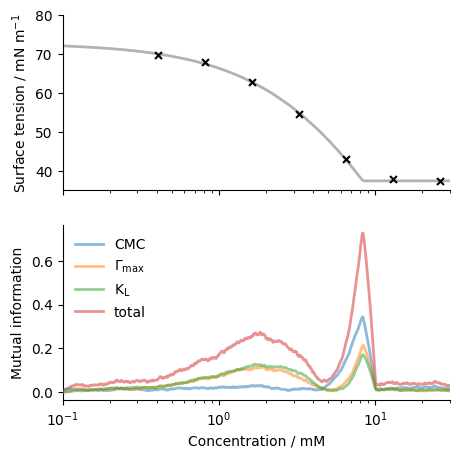

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
ax1.plot(x_new_1, st_fit_mu, c="black", alpha=0.3, linewidth=2)
ax1.scatter(
    x_obs_1,
    y_obs_1,
    s=25,
    zorder=100,
    color="black",
    marker="x",
    alpha=1,
)

# plot mutual information
linewidth_mi = 2 
label_convert_dict = {
    "cmc": "CMC",
    "gamma_max": r"$\Gamma_{\max}$",
    "Kad": r"K$_{\mathrm{L}}$",
}
for parameter in parameters:
    ax2.plot(
        x_new_1,
        mutual_info[parameter],
        label=label_convert_dict[parameter],
        zorder=10,
        alpha=0.5,
        linewidth=linewidth_mi,
    )
ax2.plot(x_new_1, U_total, label="total", alpha=0.5, linewidth=linewidth_mi)


# axes settings
fontsize_labels = 10

ax1.set_ylim(35, 80)
ax2.set_xlim(0.1, 30)
ax1.set_xlim(0.1, 30)
ax2.set_xscale("log")
ax2.set_xlabel("Concentration / mM", fontsize=fontsize_labels)
ax2.set_ylabel(r"Mutual information", fontsize=fontsize_labels)
ax1.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)
ax2.legend(fontsize=10, loc="upper left", frameon=False)

sns.despine()

# save
fig.savefig(
    "figures/figure3/active_learning.svg",
    dpi=figure_dpi,
    bbox_inches="tight",
)

## Figure 4

import data and fit model

In [39]:
# import data surfactant 1
experiment_tag = "AULAB_PSP0073"
solution = "CTAB"
results = pd.read_csv(f"data/experiments/{experiment_tag}/results.csv")
results_solution_1 = results[results["solution"] == solution]
point_types_1 = results_solution_1["point type"]

# import data surfactant 2
experiment_tag = "AULAB_PSP0076/part_3"
solution = "SDBS_1_1"
results = pd.read_csv(f"data/experiments/{experiment_tag}/results.csv")
results_solution_2 = results[results["solution"] == solution]
point_types_2 = results_solution_2["point type"]

# fit model surfactant 1
c_1 = results_solution_1["concentration"] / 1000
st_1 = results_solution_1["surface tension eq. (mN/m)"] / 1000
obs_1 = (c_1, st_1)
parameters = ["cmc", "gamma_max", "Kad"]
print("Fitting model for surfactant 1...")
post_pred_1, x_new_1 = fit_model(
    obs_1, model=szyszkowski_model, parameters=parameters, outlier_check=False
)
x_new_1 = x_new_1 * 1000
x_obs_1, y_obs_1 = obs_1
x_obs_1 = x_obs_1 * 1000
y_obs_1 = y_obs_1 * 1000
st_fit_mean_1 = post_pred_1["obs"].mean(axis=0) * 1000
st_fit_std_1 = post_pred_1["obs"].std(axis=0) * 1000

# fit model surfactant 2
c_2 = results_solution_2["concentration"] / 1000
st_2 = results_solution_2["surface tension eq. (mN/m)"] / 1000
obs_2 = (c_2, st_2)
print("Fitting model for surfactant 2...")
post_pred_2, x_new_2 = fit_model(
    obs_2, model=szyszkowski_model, parameters=parameters, outlier_check=False
)
x_new_2 = x_new_2 * 1000
x_obs_2, y_obs_2 = obs_2
x_obs_2 = x_obs_2 * 1000
y_obs_2 = y_obs_2 * 1000
st_fit_mean_2 = post_pred_2["obs"].mean(axis=0) * 1000
st_fit_std_2 = post_pred_2["obs"].std(axis=0) * 1000

Fitting model for surfactant 1...


sample: 100%|██████████| 1500/1500 [00:03<00:00, 457.16it/s, 63 steps of size 5.74e-02. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad   1420.59    191.16   1418.68   1087.37   1716.53    299.10      1.00
        cmc      0.00      0.00      0.00      0.00      0.00    486.92      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    270.91      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    510.01      1.00

Number of divergences: 0
Fitting model for surfactant 2...


sample: 100%|██████████| 1500/1500 [00:02<00:00, 590.00it/s, 23 steps of size 1.23e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad   2180.22    172.87   2175.37   1891.71   2453.27    253.57      1.00
        cmc      0.00      0.00      0.00      0.00      0.00    162.16      1.01
  gamma_max      0.00      0.00      0.00      0.00      0.00    175.74      1.01
      sigma      0.00      0.00      0.00      0.00      0.00    402.32      1.00

Number of divergences: 0


plot the isotherms

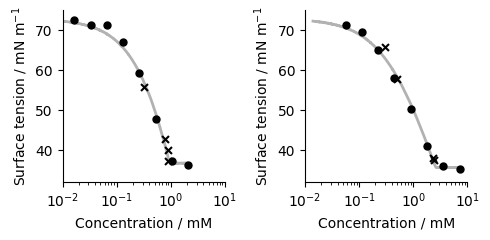

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.5))

explore_mask_1 = point_types_1 == "explore"
exploit_mask_1 = point_types_1 == "exploit"

explore_mask_2 = point_types_2 == "explore"
exploit_mask_2 = point_types_2 == "exploit"

# plot surfactant 1 isotherm
ax1.plot(
    x_new_1,
    st_fit_mean_1,
    color="black",
    alpha=0.3,
    linewidth=2,
    label="fit",
)
ax1.scatter(
    x_obs_1[explore_mask_1],
    y_obs_1[explore_mask_1],
    s=25,
    zorder=100,
    color="black",
    marker="o",
    alpha=1,
    label="explore",
)
ax1.scatter(
    x_obs_1[exploit_mask_1],
    y_obs_1[exploit_mask_1],
    s=25,
    zorder=100,
    color="black",
    marker="x",
    alpha=1,
    label="exploit",
)

# plot surfactant 2 isotherm
ax2.plot(
    x_new_2,
    st_fit_mean_2,
    color="black",
    alpha=0.3,
    linewidth=2,
    label="fit",
)
ax2.scatter(
    x_obs_2[explore_mask_2],
    y_obs_2[explore_mask_2],
    s=25,
    zorder=100,
    color="black",
    marker="o",
    alpha=1,
    label="explore",
)
ax2.scatter(
    x_obs_2[exploit_mask_2],
    y_obs_2[exploit_mask_2],
    s=25,
    zorder=100,
    color="black",
    marker="x",
    alpha=1,
    label="exploit",
)
# axes settings
fontsize_labels = 10
ax1.set_xlabel("Concentration / mM", fontsize=fontsize_labels)
ax2.set_xlabel("Concentration / mM", fontsize=fontsize_labels)
ax1.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)
ax2.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=fontsize_labels)

ax1.set_ylim(32, 75)
ax2.set_ylim(32, 75)
ax1.set_xlim(0.01, 10)
ax2.set_xlim(0.01, 10)

ax1.set_xscale("log")
ax2.set_xscale("log")

sns.despine()
plt.tight_layout()
# save
fig.savefig(
    "figures/figure4/isotherm_examples.svg",
    dpi=figure_dpi,
    bbox_inches="tight",
)

## Figure 5

### mixture space exploration

import data & fit model

In [2]:
mixture = "SOS_SDS"
results = pd.read_csv(f"data/mixture/{mixture}/mixture_data_{mixture}.csv")
# replace surface tension values with a value higher than 72.8 mN/m with 72.8 mN/m
# results.loc[
#     results["surface tension eq. (mN/m)"] > 72.8, "surface tension eq. (mN/m)"
# ] = 72.8
alphas = results["alpha"].unique()
parameters = ["cmc", "gamma_max", "Kad"]
fit_results = {}
for alpha in alphas:
    print(f"Fitting for alpha = {alpha}")
    results_alpha = results[results["alpha"] == alpha]
    c = results_alpha["concentration"] / 1000
    st = results_alpha["surface tension eq. (mN/m)"] / 1000
    obs = (c, st)
    post_pred, x_new = fit_model(
        obs, model=szyszkowski_model, parameters=parameters, outlier_check=False
    )
    fit_results[alpha] = {
        "post_pred": post_pred,
        "x_new": x_new,
    }
    print("done fitting for alpha =", alpha)

Fitting for alpha = 0.0


sample: 100%|██████████| 1500/1500 [00:03<00:00, 457.18it/s, 59 steps of size 4.14e-02. acc. prob=0.96]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad    204.31     19.19    203.69    170.37    232.91    316.04      1.00
        cmc      0.01      0.00      0.01      0.01      0.01    444.07      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    266.29      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    412.51      1.00

Number of divergences: 0
done fitting for alpha = 0.0
Fitting for alpha = 0.145


sample: 100%|██████████| 1500/1500 [00:03<00:00, 429.86it/s, 127 steps of size 2.00e-02. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     86.01     21.48     87.99     53.26    121.94    209.79      1.01
        cmc      0.01      0.00      0.01      0.01      0.01    182.30      1.01
  gamma_max      0.00      0.00      0.00      0.00      0.00    134.69      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    299.87      1.00

Number of divergences: 0
done fitting for alpha = 0.145
Fitting for alpha = 0.311


sample: 100%|██████████| 1500/1500 [00:03<00:00, 433.09it/s, 67 steps of size 2.75e-02. acc. prob=0.95]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     76.35     14.12     76.05     53.39     98.70    215.05      1.00
        cmc      0.01      0.00      0.01      0.01      0.01    333.86      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    197.50      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    499.87      1.00

Number of divergences: 0
done fitting for alpha = 0.311
Fitting for alpha = 0.504


sample: 100%|██████████| 1500/1500 [00:03<00:00, 440.51it/s, 255 steps of size 8.28e-03. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     24.46     11.14     23.92      7.21     43.78    229.57      1.00
        cmc      0.01      0.00      0.01      0.01      0.01    219.76      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    149.60      1.01
      sigma      0.00      0.00      0.00      0.00      0.00    342.64      1.01

Number of divergences: 0
done fitting for alpha = 0.504
Fitting for alpha = 0.731


sample: 100%|██████████| 1500/1500 [00:03<00:00, 461.66it/s, 127 steps of size 1.84e-02. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     26.37      7.34     26.41     17.07     39.65     63.91      1.00
        cmc      0.02      0.00      0.02      0.01      0.02     75.96      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00     58.77      1.02
      sigma      0.00      0.00      0.00      0.00      0.00    306.20      1.00

Number of divergences: 0
done fitting for alpha = 0.731
Fitting for alpha = 1.0


sample: 100%|██████████| 1500/1500 [00:03<00:00, 456.73it/s, 23 steps of size 6.29e-02. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kad     75.94      6.41     75.28     66.06     86.66    184.03      1.00
        cmc      0.11      0.01      0.11      0.11      0.13    107.91      1.00
  gamma_max      0.00      0.00      0.00      0.00      0.00    151.01      1.00
      sigma      0.00      0.00      0.00      0.00      0.00    317.63      1.00

Number of divergences: 0
done fitting for alpha = 1.0


Extract properties

In [3]:
data = []
alphas = results["alpha"].unique()

for alpha, fit in fit_results.items():

    row = [alpha]

    for parameter in parameters:

        if parameter == "cmc":

            row.append(fit["post_pred"][parameter].mean(axis=0) * 1000)

        else:

            row.append(fit["post_pred"][parameter].mean(axis=0))

    # Calculate st_at_cmc
    st_at_cmc, st_at_cmc_err, st_at_cmc_relative_err = calc_st_at_cmc(
        fit["x_new"], fit["post_pred"]
    )
    row.append(st_at_cmc * 1000)  # Convert to mN/m

    # Calculate C20
    c20 = calculate_C20(fit["x_new"], fit["post_pred"])
    row.append(c20)  # C20 in mM

    data.append(row)


columns = ["alpha"] + parameters + ["st_at_cmc"] + ["C20"]

df_properties = pd.DataFrame(data, columns=columns)
# print(df_properties)

Plot isotherms

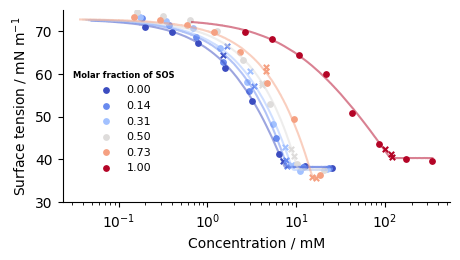

In [22]:
fig, ax = plt.subplots(figsize=(5, 2.5))
size_marker = 15

# Normalize alpha values for colormap
alphas = results["alpha"].unique()
norm = plt.Normalize(alphas.min(), alphas.max())
cmap = plt.cm.coolwarm

scatter_handles = []
for alpha in alphas:
    color = cmap(norm(alpha))
    results_alpha = results[results["alpha"] == alpha]
    fit_alpha = fit_results[alpha]
    point_types = results_alpha["point type"]
    explore_mask = point_types == "explore"
    exploit_mask = point_types == "exploit"
    x_obs = results_alpha["concentration"]
    y_obs = results_alpha["surface tension eq. (mN/m)"]
    handle = ax.scatter(
        x_obs[explore_mask],
        y_obs[explore_mask],
        color=color,
        marker="o",
        zorder=15,
        s=size_marker,
        label=f"{alpha:.2f}",
    )
    scatter_handles.append(handle)
    ax.scatter(
        x_obs[exploit_mask],
        y_obs[exploit_mask],
        color=color,
        marker="x",
        s=size_marker,
        zorder=15,
    )
    x_new = fit_alpha["x_new"] * 1000
    st_fit_mean = fit_alpha["post_pred"]["obs"].mean(axis=0) * 1000  # Convert to mN/m
    ax.plot(x_new, st_fit_mean, c=color, alpha=0.5, zorder=20)

ax.set_xscale("log")
ax.set_ylim(30, 75)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add legend for alpha colors
ax.legend(
    handles=scatter_handles,
    title="Molar fraction of SOS",
    # title_fontsize=6,
    title_fontproperties={"weight": "bold", "size": 6},
    fontsize=8,
    loc="lower left",
    bbox_to_anchor=(0, 0.1),
    frameon=False,
)
fontsize_labels = 10
ax.set_xlabel("Concentration / mM", fontsize=10)
ax.set_ylabel("Surface tension / $\mathrm{mN \ m^{-1}}$", fontsize=10)
sns.despine()

# save
fig.savefig(
    "figures/figure5/mixture_isotherm.svg",
    dpi=figure_dpi,
    bbox_inches="tight",
)

interaction parameter plot: micellization 

Fitted interaction parameter β: -0.7771


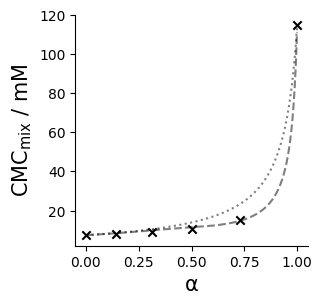

In [20]:
alpha_list = [a for a in df_properties["alpha"].to_list() if a != 0 and a != 1]
CMCmix_list = [
    c
    for a, c in zip(df_properties["alpha"].to_list(), df_properties["cmc"].to_list())
    if a != 0 and a != 1
]

#! should fix, the cmc are otherway around
CMC2 = df_properties[df_properties["alpha"] == 0]["cmc"].values[
    0
]  # CMC of pure compound 1
CMC1 = df_properties[df_properties["alpha"] == 1]["cmc"].values[
    0
]  # CMC of pure compound 2

# Initial guess for beta
initial_beta = 0.0

# Optimize beta
result = minimize(
    objective,
    initial_beta,
    args=(alpha_list, CMCmix_list, CMC1, CMC2),
    method="Nelder-Mead",
)

if result.success:
    fitted_beta = result.x[0]
    print(f"Fitted interaction parameter β: {fitted_beta:.4f}")
else:
    print("Optimization failed.")
    fitted_beta = initial_beta  # Fallback to initial guess

# Plotting the results

# Generate fitted CMCmix values across a range of alpha
alpha_fit = np.linspace(0.001, 1, 1000)
CMCmix_fit_non_ideal = []
CMCmix_fit_ideal = []
for alpha in alpha_fit:
    try:
        CMCmix_non_ideal = cmc_mix_non_ideal(CMC1, CMC2, alpha, fitted_beta)
        CMCmix_fit_non_ideal.append(CMCmix_non_ideal)
    except RuntimeError:
        CMCmix_fit_non_ideal.append(np.nan)

    CMCmix_ideal = cmc_mix_ideal(CMC1, CMC2, alpha)
    CMCmix_fit_ideal.append(CMCmix_ideal)

# Plotting
plt.figure(figsize=(3, 3))
plt.plot(
    alpha_fit,
    CMCmix_fit_non_ideal,
    label="Non-Ideal",
    linestyle="--",
    color="black",
    alpha=0.5,
)
plt.plot(
    alpha_fit, CMCmix_fit_ideal, label="Ideal", linestyle=":", color="black", alpha=0.5
)
plt.scatter(
    alpha_list,
    CMCmix_list,
    label="Experimental Data",
    zorder=30,
    color="black",
    marker="x",
)
plt.scatter([0, 1], [CMC2, CMC1], zorder=30, color="black", marker="x")

sns.despine()
fontsize_labels = 15
plt.xlabel(r"$\mathrm{\alpha}$", fontsize=fontsize_labels)
plt.ylabel(r"CMC$_{\mathrm{mix}}$ / mM", fontsize=fontsize_labels)

# save
plt.savefig(
    "figures/figure5/interaction_parameter_micellization.svg",
    dpi=figure_dpi,
    bbox_inches="tight",
)

interaction parameter plot: adsorption

Fitted interaction parameter β: -0.6450


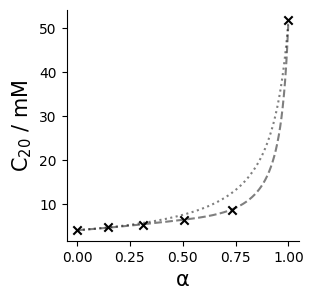

In [21]:
alpha_list = [a for a in df_properties["alpha"].to_list() if a != 0 and a != 1]
CMCmix_list = [
    c
    for a, c in zip(df_properties["alpha"].to_list(), df_properties["C20"].to_list())
    if a != 0 and a != 1
]

#! should fix, the cmc are otherway around
CMC2 = df_properties[df_properties["alpha"] == 0]["C20"].values[
    0
]  # CMC of pure compound 1
CMC1 = df_properties[df_properties["alpha"] == 1]["C20"].values[
    0
]  # CMC of pure compound 2

# Initial guess for beta
initial_beta = 0.0

# Optimize beta
result = minimize(
    objective,
    initial_beta,
    args=(alpha_list, CMCmix_list, CMC1, CMC2),
    method="Nelder-Mead",
)

if result.success:
    fitted_beta = result.x[0]
    print(f"Fitted interaction parameter β: {fitted_beta:.4f}")
else:
    print("Optimization failed.")
    fitted_beta = initial_beta  # Fallback to initial guess

# Plotting the results

# Generate fitted CMCmix values across a range of alpha
alpha_fit = np.linspace(0.001, 1, 1000)
CMCmix_fit_non_ideal = []
CMCmix_fit_ideal = []
for alpha in alpha_fit:
    try:
        CMCmix_non_ideal = cmc_mix_non_ideal(CMC1, CMC2, alpha, fitted_beta)
        CMCmix_fit_non_ideal.append(CMCmix_non_ideal)
    except RuntimeError:
        CMCmix_fit_non_ideal.append(np.nan)

    CMCmix_ideal = cmc_mix_ideal(CMC1, CMC2, alpha)
    CMCmix_fit_ideal.append(CMCmix_ideal)

# Plotting
plt.figure(figsize=(3, 3))
plt.plot(
    alpha_fit, CMCmix_fit_non_ideal, label="Non-Ideal", linestyle="--", color="black", alpha=0.5
)
plt.plot(alpha_fit, CMCmix_fit_ideal, label="Ideal", linestyle=":", color="black", alpha=0.5)
plt.scatter(
    alpha_list,
    CMCmix_list,
    label="Experimental Data",
    zorder=30,
    color="black",
    marker="x",
)
plt.scatter([0, 1], [CMC2, CMC1], zorder=30, color="black", marker="x")

sns.despine()
fontsize_labels = 15
plt.xlabel(r"$\mathrm{\alpha}$", fontsize=fontsize_labels)
plt.ylabel(r"C$_{\mathrm{20}}$ / mM", fontsize=fontsize_labels)

# save
plt.savefig(
    "figures/figure5/interaction_parameter_adsorption.svg",
    dpi=figure_dpi,
    bbox_inches="tight",
)